In [1]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)
#config.update('jax_debug_nans', True) #this checks outputs for nans everytime and reruns the function with non-optimized mode.


import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
from NODE_fns import NODE_nobias as NODE
from jax import grad, random, jit, jacobian, jacfwd, jacrev, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import while_loop, fori_loop, scan, cond
from jax.experimental.ode import odeint
import pickle
key = random.PRNGKey(0)
import timeit

In [2]:
# Material parameters:
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 10000
tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*K_m
mu = 77.77 #=shear_mod
K = 10000

In [3]:
# dΦ/dtau_NEQ
# Govindjee Φ
def dphidtaui_gov(tau_i, etad = 1360, etav = 175000): #This function takes in tau matrix and spits out dphidtau
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]

# N-ODE based Φ
with open('saved/norm_w.npy', 'rb') as f:
    [inp_mean, inp_stdv, out_mean, out_stdv] = pickle.load(f)
with open('saved/params.npy', 'rb') as f:
    params = pickle.load(f)

def dPhi(taui, params):
    NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = params
    
    tau1 = taui[0]
    tau2 = taui[1]
    tau3 = taui[2]

    tau1 = (tau1 - inp_mean)/inp_stdv
    tau2 = (tau2 - inp_mean)/inp_stdv
    tau3 = (tau3 - inp_mean)/inp_stdv

    N1 = NODE(tau1, NODE1_params)
    N2 = NODE(tau1 + tau2, NODE2_params)
    N3 = NODE(tau1 + tau2 + tau3, NODE3_params)
    N4 = NODE(tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3, NODE4_params)
    N5 = NODE(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NODE5_params)

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    Phi1 = Phi1*out_stdv + out_mean
    Phi2 = Phi2*out_stdv + out_mean
    Phi3 = Phi3*out_stdv + out_mean
    return [Phi1, Phi2, Phi3]

In [4]:
def tau_NEQ(lm1e, lm2e, lm3e):
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    return tau_A

def sigma(inputs):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = inputs
    J = lm1*lm2*lm3
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    tau_NEQ = np.array([[tau_A[0], 0, 0],
                        [0, tau_A[1], 0],
                        [0, 0, tau_A[2]]]) #Since stress and strain are coaxial in the isotropic case

    b = np.array([[lm1**2, 0, 0],
                  [0, lm2**2, 0],
                  [0, 0, lm3**2]])
    binv = np.array([[lm1**(-2), 0, 0],
                     [0, lm2**(-2), 0],
                     [0, 0, lm3**(-2)]])

    sigma_EQ = mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3)
    sigma = 1/Je*tau_NEQ + sigma_EQ
    # p = sigma[2,2]*lm3**2
    # sigma = sigma - p*binv
    return sigma
getsigma = jit(vmap(sigma))

def sigma33(inputs):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = inputs
    J = lm1*lm2*lm3
    Je = lm1e*lm2e*lm3e

    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_3 = devtau3 + 1/3*tau_NEQI #(B8)
    tau_NEQ33 = tau_3

    sigma_EQ33 = mu/J*(lm3**2-1) + 2*K*(J-1)
    sigma33 = 1/Je*tau_NEQ33 + sigma_EQ33
    return sigma33
 
dsigma33 = grad(sigma33)

In [5]:
def yprime(y, t, lm1dot, lm2dot, tpeak, params):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array([lm1dot, lm2dot])
    false_fun = lambda t: np.array([   0.0,    0.0], dtype='float64')
    lm1dot, lm2dot = cond(t<tpeak, true_fun, false_fun, t)

    tau_A = tau_NEQ(lm1e, lm2e, lm3e) 
    dphidtaui = dPhi(tau_A, params)
    # dphidtaui = dphidtaui_gov(tau_A)
    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = (lm2dot/lm2 - 0.5*dphidtaui[1])*lm2e

    d = dsigma33([lm1,lm2,lm3,lm1e,lm2e,lm3e])
    A = -(d[0]*lm1dot + d[1]*lm2dot + d[3]*lm1edot + d[4]*lm2edot)/d[2]
    B = -d[5]/d[2]

    Apr = A/lm3
    Bpr = B/lm3

    lm3edot = (Apr - 0.5*dphidtaui[2])/(1-Bpr*lm3e)*lm3e
    lm3dot = A + B*lm3edot
    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

yprimejit = jit(yprime)

In [6]:
@jit
def biaxial_visco(params, time, lm1, lm2):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak
    yprime2 = lambda y, t: yprimejit(y,t,lm1dot,lm2dot,tpeak,params)

    y0 = [1.0,1.0,1.0,1.0,1.0,1.0]
    lm1, lm2, lm3, lm1e, lm2e, lm3e = odeint(yprime2, y0, time)

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e])
    return sig, lm3, lm1e, lm2e, lm3e

In [7]:
@jit
def loss(params, time, lm1, lm2, sigma1, sigma2):
    sigma_pr,_,_,_,_ = biaxial_visco(params, time, lm1, lm2)
    loss = np.sum((sigma_pr[:,0,0]-sigma1[:])**2) + np.sum((sigma_pr[:,1,1]-sigma2[:])**2)
    return loss/lm1.shape[0]
loss_vmap = vmap(loss, in_axes=(None, 0, 0, 0, 0, 0), out_axes=0)
def batch_loss(params, time, lm1, lm2, sigma1, sigma2):
    loss = loss_vmap(params, time, lm1, lm2, sigma1, sigma2)
    loss = np.mean(loss)
    return loss

def step(loss_fn, i, opt_state, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch)
    return opt_update(i, g, opt_state)

def init_params(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    b = np.zeros(layers[i + 1])
    return Ws, b

layers = [1, 5, 5, 1]
NODE1_params = init_params(layers, key)
NODE2_params = init_params(layers, key)
NODE3_params = init_params(layers, key)
NODE4_params = init_params(layers, key)
NODE5_params = init_params(layers, key)
# params = [NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params]

def train(loss, X1, X2, X3, Y1, Y2, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        #Temporary:
        # i = tuple(np.array([[0,1,5,6,8,17,55]]))
        opt_state = step(batch_loss, it, opt_state, X1[i], X2[i], X3[i], Y1[i], Y2[i])   
        # opt_state = step(batch_loss, it, opt_state, X1[i], X2[i], X3[i], Y1[i], Y2[i])  
        if it % 10 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, X1[i], X2[i], X3[i], Y1[i], Y2[i])
            # train_loss_value = batch_loss(params, X1[i], X2[i], X3[i], Y1[i], Y2[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

In [8]:
#Load the training data
with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = onp.load(f)
with open('saved/norm_w.npy', 'rb') as f:
    [inp_mean, inp_stdv, out_mean, out_stdv] = pickle.load(f)
with open('saved/params.npy', 'rb') as f:
    params = pickle.load(f)

In [ ]:
opt_init, opt_update, get_params = optimizers.adam(1.e-6)
opt_state = opt_init(params)

params, train_loss, val_loss = train(loss, time, lmb_x, lmb_y, sgm_x, sgm_y, opt_state, key, nIter = 300)

## Testing

In [26]:
with open('saved/params.npy', 'rb') as f:
    params = pickle.load(f)
with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = onp.load(f)

j = 5
t = time[j]
lm1 = lmb_x[j]
lm2 = lmb_y[j]
sigx = sgm_x[j]
sigy = sgm_y[j]
sig,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)

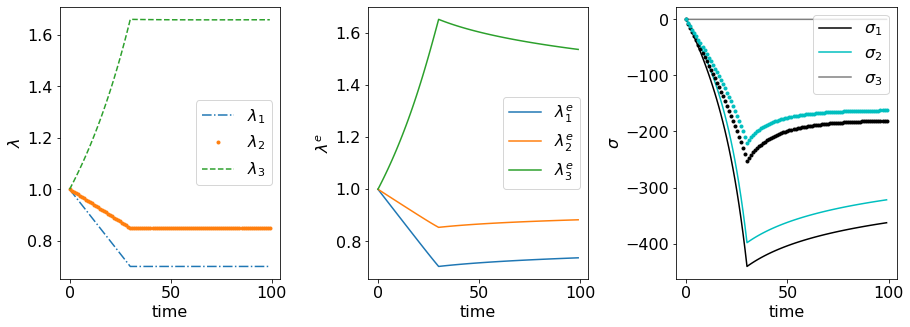

In [27]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t,  lm1, '-.',label='$\lambda_1$')
ax[0].plot(t,  lm2, '.',label='$\lambda_2$')
ax[0].plot(t,  lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t, lm1e, label='$\lambda_1^e$')
ax[1].plot(t, lm2e, label='$\lambda_2^e$')
ax[1].plot(t, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

ax[2].plot(t,sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t,sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t,sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].plot(t,sigx, 'k.')
ax[2].plot(t,sigy, 'c.')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 

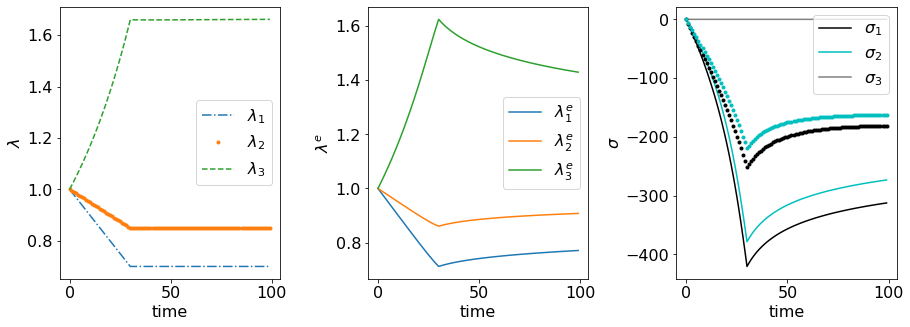

In [28]:
with open('saved/params_retrained.npy', 'rb') as f:
    params = pickle.load(f)

sig,lm3,lm1e,lm2e,lm3e = biaxial_visco(params, t, lm1, lm2)

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t,  lm1, '-.',label='$\lambda_1$')
ax[0].plot(t,  lm2, '.',label='$\lambda_2$')
ax[0].plot(t,  lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t, lm1e, label='$\lambda_1^e$')
ax[1].plot(t, lm2e, label='$\lambda_2^e$')
ax[1].plot(t, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

ax[2].plot(t,sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t,sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t,sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].plot(t,sigx, 'k.')
ax[2].plot(t,sigy, 'c.')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 